In [1]:
import sys
sys.path.append('..')

%pylab inline
plt.rcParams['figure.figsize']=(16,6)

Populating the interactive namespace from numpy and matplotlib


# NMRPro
NMRPro is a high-level wrapper for [nmrglue]() that lets you handle NMR spectra more easily. In this tutorial, I will explain the main advantages of using NMRPro directly.

Initially, NMRPro was not intended to be a standalone package. It was developed to encapsulate nmrglue functions and to faciliate the creation of web-based GUI.  

## Why use NMRPro?
### 1. Unified representation of spectra:
NMRPro reads NMR files, regardless of their format, to an NMRSpectrum object. Since all NMRSpectrum objects have the same structure, users don't have to concern about any format-specific parameters / header values.

Let's create an NMRSpectrum object:

In [2]:
import nmrpro.readers
bruker_1d = nmrpro.readers.fromBruker('../test_files/Bruker_1D/')
bruker_1d

NMRSpectrum1D([  1.25200000e+03 +2.74000000e+03j,
         7.09800000e+03 +5.60900000e+03j,
         5.17900000e+03 +3.04800000e+03j, ...,
         2.00000000e+00 +2.37083686e-11j,
        -2.00000000e+00 +1.00000000e+00j,  -1.00000000e+00 -3.00000000e+00j])

NMRSpectrum is a subclass of numpy.ndarray, so `bruker_1d` can be treated like a regular numpy.ndarray object. All functions that operate on ndarrays will accept NMRSpectrum objects as well. You can also subset the array similar to numpy:

In [3]:
bruker_1d[0:10:2]

NMRSpectrum1D([ 1252.+2740.j,  5179.+3048.j,  3806.+4724.j,  4632.+5295.j,
        5674.+5387.j])

However, unlike ndarray, NMRSpecrtum contains an extra dictionary, storing the necessary parameters the defines the spectrum.

In [4]:
bruker_1d.udic

{0: {'car': 1880.611,
  'complex': True,
  'encoding': 'direct',
  'freq': False,
  'label': '1H',
  'obs': 400.131880611,
  'size': 16310,
  'sw': 4807.69230769231,
  'time': True},
 'Name': '../test_files/Bruker_1D/',
 'ndim': 1,
 'original_format': 'Bruker'}

You can also access the [unit_conversion](http://nmrglue.readthedocs.org/en/latest/reference/generated/nmrglue.fileio.fileiobase.unit_conversion.html#nmrglue.fileio.fileiobase.unit_conversion) object.

In [5]:
# get the ppm limits of the first (and only here) dimension
bruker_1d.uc[0].ppm_limits()

(10.70761256839571, -1.3069200670527756)

### 2. Indexing with units:
NMRPro adds implicit indexing using units, such as 'ppm', 'hz' or 'ms'. You can use these units to subset the spectrum  similar to numpy.ndarray


In [6]:
# get the spectrum between 0-9 ppm.
# Note that ppm and hz are ordered from higher to lower.
bruker_1d['9ppm':'0ppm']

NMRSpectrum1D([  8.20000000e+01+22.j,   1.13000000e+02 -1.j,   1.06000000e+02-49.j,
       ...,  -1.00000000e+00 -3.j,   7.97761857e-12 +3.j,
         1.00000000e+00 -1.j])

In [7]:
# or even mix in different units
# get spectrum between 0.8 and 1 ppm, with a step of 10 Hz
# Again, because ppm and hz go from higher to lower values, 
# the step value should be negative. Otherwise the array is reversed.
bruker_1d['1ppm':'0.8ppm':'-10hz']

NMRSpectrum1D([ -7.00000000e+00 +3.00000000e+00j,
        -1.00000000e+00 -1.00000000e+00j,
         2.00000000e+00 +1.84456894e-11j,
         4.00000000e+00 +4.00000000e+00j,
         2.00000000e+00 +1.58735247e-11j,
         2.00000000e+00 +2.00000000e+00j,
         1.66409109e-11 +1.00000000e+00j,   3.00000000e+00 -4.00000000e+00j])

### 3. Automatic update of spectrum dictionary:
NMRPro processing functions updates the object's `udic` when necessary, allowing users to inspect the current state of the spectrum.

In [8]:
from nmrpro.plugins.FFT import fft
freq_domain = fft(bruker_1d)

# since we have already applied FT, the spectrum now is in the frequency domain.
# Notice 'freq' and 'time' values are now updated.
freq_domain.udic

{0: {'car': 1880.611,
  'complex': True,
  'encoding': 'direct',
  'freq': True,
  'label': '1H',
  'obs': 400.131880611,
  'size': 16310,
  'sw': 4807.69230769231,
  'time': False},
 'Name': '../test_files/Bruker_1D/',
 'ndim': 1,
 'no_transpose': False,
 'original_format': 'Bruker'}

### 4. Seamless processing of 2D spectra:
NMRPro facilitates processing of 2D spectra by applying processing functions to all dimensions automatically. For example, when `fft` is called on a 2D spectrum, it is applied to the direct dimension (F2) first, then the spectrum is transposed, and FT is applied to the indirect dimension (F1).

In [9]:
pipe_2d = nmrpro.readers.fromPipe('../test_files/Pipe_2D/bmse000281_hsqc.fid')
print 'The spectrum F1 dimension is in the ' + ('time' if pipe_2d.udic[0]['time'] else 'frquency') + ' domain'
print 'The spectrum F2 dimension is in the ' + ('time' if pipe_2d.udic[1]['time'] else 'frquency') + ' domain'

The spectrum F1 dimension is in the time domain
The spectrum F2 dimension is in the time domain


In [10]:
# Now we apply fft
pipe_2d_f = fft(pipe_2d)
print 'The spectrum F1 dimension is in the ' + ('time' if pipe_2d_f.udic[0]['time'] else 'frquency') + ' domain'
print 'The spectrum F2 dimension is in the ' + ('time' if pipe_2d_f.udic[1]['time'] else 'frquency') + ' domain'

The spectrum F1 dimension is in the frquency domain
The spectrum F2 dimension is in the frquency domain


In [11]:
# We can FT only one of the dimensions, using apply_to_dim keyword arg.
pipe_2d_f = fft(pipe_2d, apply_to_dim=[1])
print 'The spectrum F1 dimension is in the ' + ('time' if pipe_2d_f.udic[0]['time'] else 'frquency') + ' domain'
print 'The spectrum F2 dimension is in the ' + ('time' if pipe_2d_f.udic[1]['time'] else 'frquency') + ' domain'

The spectrum F1 dimension is in the time domain
The spectrum F2 dimension is in the frquency domain


The examples above also work with zero filling, phase correction and apodization functions.

### 5. Apply functions to datasets:
NMRPro let users apply batch processing to datasets without any extra code. To demonestrate this capability, I will use the [coffee dataset](http://bionmr.unl.edu/mvapack.php) which consists of 128 proton spectra for a different varieties of coffee.

In [12]:
coffees = nmrpro.readers.fromFile('../test_files/coffees.tar.gz')
print 'The coffee dataset has ' + str(len(coffees)) + ' spectra.'
coffees[0]

The coffee dataset has 128 spectra.


/Users/mohamedahmed/Envs/nmr/lib/python2.7/site-packages/nmrglue/fileio/bruker.py:299: UserWarning: Error reading the pulse program
  warn('Error reading the pulse program')


NMRSpectrum1D([  6.66664000e+05 -6.75980000e+04j,
         1.73842800e+06 -1.15499600e+06j,
        -7.44013000e+05 -1.15415500e+06j, ...,
         1.90000000e+01 +3.20000000e+01j,
        -4.90000000e+01 -4.00000000e+00j,  -1.50000000e+01 -1.00000000e+00j])

In [13]:
coffees = fft(coffees)
coffees[0].udic

{0: {'car': 2350.611,
  'complex': True,
  'encoding': 'direct',
  'freq': True,
  'label': '1H',
  'obs': 500.132350611,
  'size': 16310,
  'sw': 6009.61538461538,
  'time': False},
 'Name': '/var/folders/4t/0q9wwbp55tdd_nfzk3wrxj1c0000gn/T/coffees/001',
 'ndim': 1,
 'no_transpose': False,
 'original_format': 'Bruker'}

Now all the 128 spectra are in the frequency domain. Let's have a look at them.

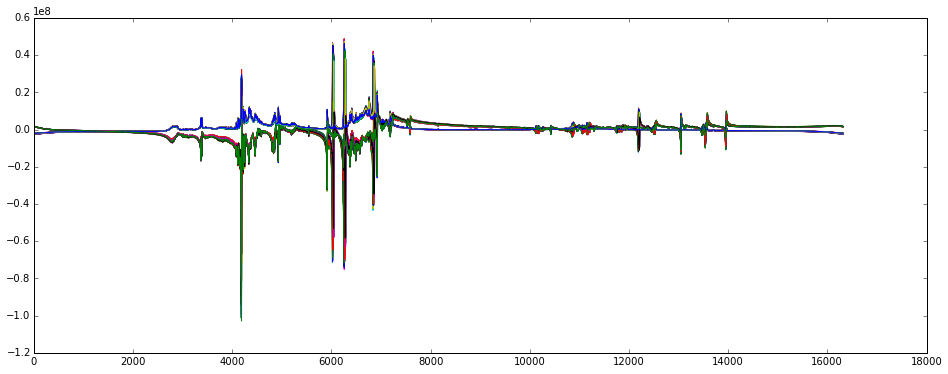

In [14]:
import matplotlib.pyplot as plt
[plt.plot(p.real_part()) for p in coffees]
plt.show()

Well, it looks like wee need phase correction.

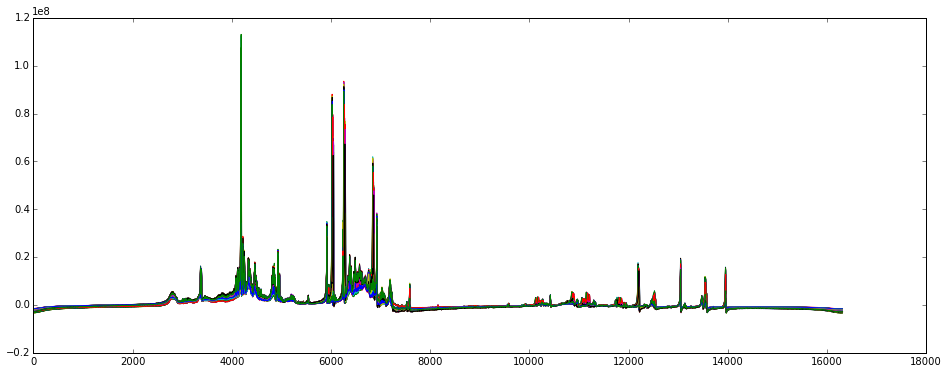

In [15]:
from nmrpro.plugins.phasing import autops
coffees = autops(coffees)
[plt.plot(p.real_part()) for p in coffees]
plt.show()

**Perfect!** Now spectra are ready for analysis.